In [2]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import cv2

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

from math import atan2, degrees

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
img_size = 224
def resize_img(im):
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(img_size) / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
      value=[0, 0, 0])
    return new_im, ratio, top, left

In [5]:
class CatDataset(Dataset):
    
    def __init__(self, images, labels, transform):
        
        self.imgs = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        
        return len(self.imgs)
 
    def __getitem__(self, idx):

        image = self.imgs[idx]
        image = image[...,::-1].copy()
        image = self.transform(image)
        label = np.array(self.labels[idx])
            
        return image, label 

In [6]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

test_transformer = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

def Catface_dataloader(img):
    
    test_inputs = []
    test_inputs.append(img)
    test_labels = [0 for i in range(4)]
            
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                 batch_size = 1, shuffle = False)
    return test_dataloader

def Lmks_dataloader(img):

    test_inputs = []
    test_inputs.append(img)
    test_labels = [0 for i in range(18)]
    test_dataloader = DataLoader(CatDataset(test_inputs,test_labels,test_transformer),
                                 batch_size = 1, shuffle = False)
    return test_dataloader

In [7]:
class CatFaceModule(nn.Module):

    def __init__(self):
        super(CatFaceModule,self).__init__()
        v = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        v.classifier[1] = nn.Linear(v.last_channel, 4)
        self.layer1 = v
               
    def forward(self, x):
        out = self.layer1(x)
        return out
    
class LmksModule(nn.Module):
    def __init__(self):
        super(LmksModule,self).__init__()
        v = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
        v.classifier[1] = nn.Linear(v.last_channel, 18)
        self.layer1 = v
               
    def forward(self, x):
        out = self.layer1(x)
        return out

In [11]:
#the path of models
cat_face_model_path = "mobilenet_RMSELoss500.ph"
lmks_model_path = "mobilenet_RMSELoss100_36.ph"

In [12]:
#load the models
cat_model = CatFaceModule().to(device)
cat_model.load_state_dict(torch.load(cat_face_model_path))
cat_model.eval()

lmks_model = LmksModule().to(device)
lmks_model.load_state_dict(torch.load(lmks_model_path))
lmks_model.eval()

Using cache found in C:\Users\USER/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\USER/.cache\torch\hub\pytorch_vision_v0.6.0


LmksModule(
  (layer1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)

### 改變測試檔名後只需要重新執行下方的cell就好了

In [13]:
#the path of the image you want to test
img_path = "cat1.jpg"

In [14]:

#read the image
img = cv2.imread(img_path)
ori_img = img.copy()
result_img = img.copy()
img, ratio, top, left = resize_img(img)
# plt.figure()
# plt.imshow(img)
predicted = []

#catface predicted
catface_dataloader = Catface_dataloader(img)
for i, (x, label) in enumerate(catface_dataloader) :
    with torch.no_grad(): 
            x, label = x.to(device), label.to(device)
            output = cat_model(x) 
            #loss = criterion(output, label.long()) 
            predicted = output.data[0].reshape((-1, 2))

#the position of the cat face box
pre_bb = predicted.cpu().numpy()
#print(pre_bb)

#the positoin of the cat face box when it at the origin image
ori_bb = ((pre_bb - np.array([left, top])) / ratio).astype(np.int)
#print(ori_bb)

#cut the face image
center = np.mean(ori_bb, axis=0)
face_size = max(np.abs(ori_bb[1] - ori_bb[0]))
new_bb = np.array([
    center - face_size * 0.6,
    center + face_size * 0.6
    ]).astype(np.int)
new_bb = np.clip(new_bb, 0, 99999)
face_img = ori_img[new_bb[0][1]:new_bb[1][1], new_bb[0][0]:new_bb[1][0]]
# plt.figure()
# plt.imshow(face_img)

face_img, face_ratio, face_top, face_left = resize_img(face_img)

#landmark prediction
lmks_dataloader = Lmks_dataloader(face_img)
for i, (x, label) in enumerate(lmks_dataloader) :
    with torch.no_grad(): 
            x, label = x.to(device), label.to(device)
            output = lmks_model(x) 
            #loss = criterion(output, label.long()) 
            predicted = output.data[0].reshape((-1, 2))


pred_lmks = predicted.cpu().numpy()
#print(pred_lmks)

new_lmks = ((pred_lmks - np.array([face_left, face_top])) / face_ratio).astype(np.int)
ori_lmks = new_lmks + new_bb[0]

ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)

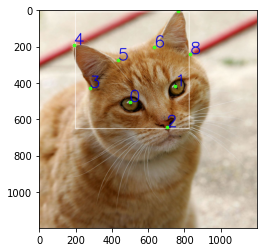

In [15]:
# show the result we predicted

cv2.rectangle(ori_img, pt1=tuple(ori_bb[0]), pt2=tuple(ori_bb[1]), color=(255, 255, 255), thickness=2)

for i, l in enumerate(ori_lmks):
    cv2.putText(ori_img, str(i), tuple(l), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 227), 3, cv2.LINE_AA)
    #cv2.circle(ori_img, center=tuple(l), radius=1, color=(255, 255, 255), thickness=10)

plt.figure()
for k in range(len(ori_lmks)):
    plt.scatter(x = ori_lmks[k][0], y = ori_lmks[k][1], s = 7, color = "#40FF1E")
plt.imshow(ori_img)

In [16]:
def angle_between(p1, p2):
    xDiff = p2[0] - p1[0]
    yDiff = p2[1] - p1[1]
    return degrees(atan2(yDiff, xDiff))

def overlay_transparent(background_img, img_to_overlay_t, x, y, overlay_size=None):
    bg_img = background_img.copy()
    # convert 3 channels to 4 channels
    if bg_img.shape[2] == 3:
        bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2BGRA)

    if overlay_size is not None:
        img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

    b, g, r, a = cv2.split(img_to_overlay_t)

    mask = cv2.medianBlur(a, 5)

    h, w, _ = img_to_overlay_t.shape
    roi = bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)]

    img1_bg = cv2.bitwise_and(roi.copy(), roi.copy(), mask=cv2.bitwise_not(mask))
    img2_fg = cv2.bitwise_and(img_to_overlay_t, img_to_overlay_t, mask=mask)

    bg_img[int(y-h/2):int(y+h/2), int(x-w/2):int(x+w/2)] = cv2.add(img1_bg, img2_fg)

    # convert 4 channels to 4 channels
    bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGRA2BGR)

    return bg_img

In [25]:
## initial cat
cat = result_img
rgb = 0 ## cat is bgr

In [26]:
cv2.imwrite('output.jpg', cat)

True

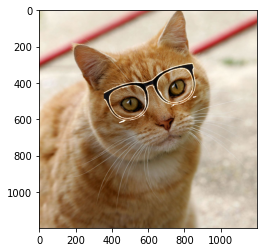

In [27]:
## add glasses
glasses = cv2.imread('glasses.png', cv2.IMREAD_UNCHANGED)

#plt.figure()
#plt.imshow(glasses)

glasses_center = np.mean([ori_lmks[0], ori_lmks[1]], axis=0)
glasses_size = np.linalg.norm(ori_lmks[0] - ori_lmks[1]) * 2
  
angle = -angle_between(ori_lmks[0], ori_lmks[1])
M = cv2.getRotationMatrix2D((glasses.shape[1] / 2, glasses.shape[0] / 2), angle, 1)
rotated_glasses = cv2.warpAffine(glasses, M, (glasses.shape[1],glasses.shape[0]))

if rgb == 1:
    cat = cat[:,:,::-1] ## convert to bgr
    rgb = 1
if rgb == 0:
    rgb = 1

try:
    cat = overlay_transparent(cat, rotated_glasses, glasses_center[0], glasses_center[1], overlay_size=(int(glasses_size), int(glasses.shape[0] * glasses_size / glasses.shape[1])))
except:
    print('failed overlay image')
    
#cv2.imshow('ori_img', ori_img)
#cv2.imshow('result', result_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cat = cat[:,:,::-1] ##轉成rgb 多執行一次會變回bgr
plt.imshow(cat)
plt.show()

In [28]:
cv2.imwrite('output1.jpg', cat)

True

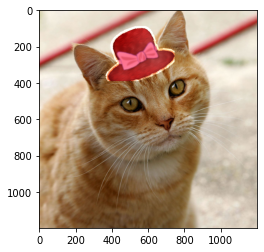

In [24]:
## add hat
hat = cv2.imread('hat1.png', cv2.IMREAD_UNCHANGED)

#plt.figure()
#plt.imshow(hat)

hat_center = np.mean([ori_lmks[5], ori_lmks[6]], axis=0)
hat_size = np.linalg.norm(ori_lmks[5] - ori_lmks[6]) * 2
  
angle = -angle_between(ori_lmks[5], ori_lmks[6])
M = cv2.getRotationMatrix2D((hat.shape[1] / 2, hat.shape[0] / 2), angle, 1)
rotated_hat = cv2.warpAffine(hat, M, (hat.shape[1],hat.shape[0]))

if rgb == 1:
    cat = cat[:,:,::-1] ## convert to bgr
    rgb = 1
if rgb == 0:
    rgb = 1

try:
    cat = overlay_transparent(cat, rotated_hat, hat_center[0], hat_center[1], overlay_size=(int(hat_size), int(hat.shape[0] * hat_size / hat.shape[1])))
except:
    print('failed overlay image')
    
#cv2.imshow('ori_img', ori_img)
#cv2.imshow('result', result_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cat = cat[:,:,::-1] ##轉成rgb 多執行一次會變回bgr
plt.imshow(cat)
plt.show()

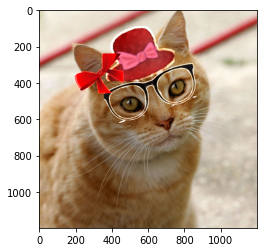

In [22]:
## add bow
bow = cv2.imread('bow.png', cv2.IMREAD_UNCHANGED)

#plt.figure()
#plt.imshow(bow)

bow_center = np.mean([ori_lmks[3], ori_lmks[5]], axis=0)
bow_size = np.linalg.norm(ori_lmks[3] - ori_lmks[5]) * 1.5
  
angle = -angle_between(ori_lmks[3], ori_lmks[5])
M = cv2.getRotationMatrix2D((bow.shape[1] / 2, bow.shape[0] / 2), angle, 1)
rotated_bow = cv2.warpAffine(bow, M, (bow.shape[1],bow.shape[0]))

if rgb == 1:
    cat = cat[:,:,::-1] ## convert to bgr
    rgb = 1
if rgb == 0:
    rgb = 1

try:
    cat = overlay_transparent(cat, rotated_bow, bow_center[0], bow_center[1], overlay_size=(int(bow_size), int(bow.shape[0] * bow_size / bow.shape[1])))
except:
    print('failed overlay image')
    
#cv2.imshow('ori_img', ori_img)
#cv2.imshow('result', result_img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cat = cat[:,:,::-1] ##轉成rgb 多執行一次會變回bgr
plt.imshow(cat)
plt.show()